# Regularyzacja Sieci Neuronowych

Za pomocą poniższego skryptu proszę pobrać zbiór danych - jest to zmniejszona wersja MNISTa na potrzeby ćwiczenia. Jeśli sieci uczą się zbyt wolno, można spróbować dostosować parametr `shrinkage`. Mówi on o tym, jak duża część zbioru danych jest wczytywana.

In [1]:
%matplotlib inline
import torch
from utils import load_mnist, show_results, ModelTrainer
from checker import test_droput, test_bn


torch.manual_seed(44)

train_dataset = load_mnist(train=True, shrinkage=0.01)
test_dataset = load_mnist(train=False, shrinkage=0.1)

D:\Anaconda\envs\ml\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


Poniższy blok ustawia parametry wspólne dla wszystkich porównywanych w notebooku modeli. Powinny być one ustawione tak, aby wszystkie modele zdążyły się nauczyć zadania do granic swoich możliwości (wypłaszczenie funkcji kosztu) - zaproponowane parametry powinny być w porządku, ale modele mogą liczyć się powoli.

In [2]:
n_epochs = 300
learning_rate = 0.05
batch_size = 128

trainer = ModelTrainer(train_dataset, test_dataset, batch_size=batch_size)

Następnie przy użyciu modułu `torch.nn.Sequential`, który tworzy sieć neuronową przez sekwencyjne łączenie podanych warstw, budujemy sieć neuronową z 2 warstwami ukrytymi o wielkości 256 i aktywacją ReLU między nimi. Sieć ta posłuży nam jako baseline, a w dalszej części notebooka będziemy dodawać do modelu dodatkowe warstwy i porównywać wyniki.

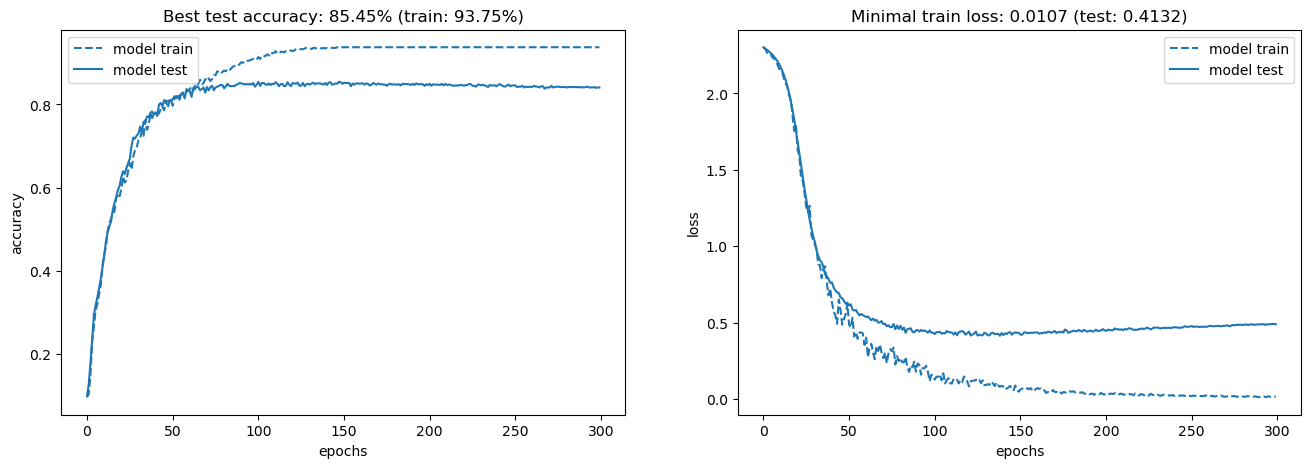

In [3]:
model = torch.nn.Sequential(torch.nn.Linear(784, 256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 10))

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
history = trainer.train(model, optimizer, n_epochs=n_epochs)
show_results(model=history)

Sieć osiąga około 85,5% dokładności $^*$ na zbiorze testowym. Na wykresie funkcji kosztu widać, że krzywa testowa w okolicach 100-tnej epoki $^*$ zaczyna się unosić, a dokładność przestaje rosnąć. Świadczy to o tym, że model zaczyna za bardzo dopasowywać się do danych (**overfitting**). Aby otrzymać najlepszy model dla tej architektury, należałoby wczytać parametry z momentu, gdy dokładność testowa była najwyższa (tzw. **early stopping**). W dalszej części rozważymy architektury z regularyzacjami poprawiającymi ten wynik.

$^*$ liczby dotyczą proponowanych domyślnych parametrów

### Regularyzacje Oparte o Funkcję Kosztu

Podstawowym sposobem regularyzacji, w którym nie ingerujemy w architekturę, jest dodanie do funkcji kosztu $J(\Theta;X,y)$ kary $\Omega(\Theta)$ związanej z parametrami. Kara jest regulowana przez współczynnik $\alpha \in [0, \infty)$.

\begin{equation*}
\tilde{J}(\Theta;X,y) = J(\Theta;X,y) + \alpha \Omega(\Theta)
\end{equation*}

Podstawowym wyborem przy doborze kary jest norma **L1** lub **L2** na wagach sieci. Zwykle dążymy do uproszczenia modelu, a więc zmniejszenia wariancji, dlatego **norma jest stosowana tylko na wagach, z pominięciem biasów**.

### Zadanie 1. Dropout (3 pkt.)

Dropout jest warstwą „wyłączającą” część neuronów, przez co model staje się bardziej odporny na overfitting.

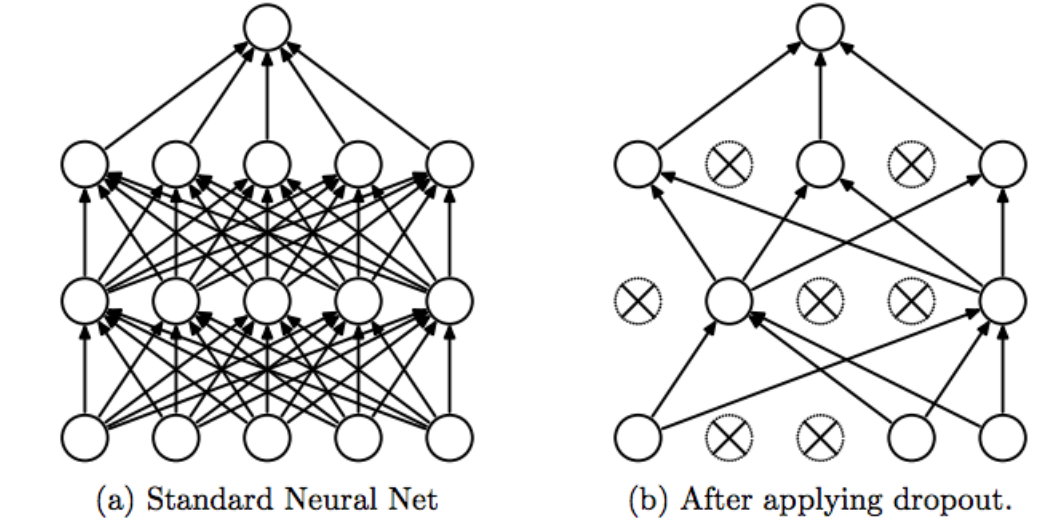

Pytania: 

1. Jaka intuicja regularyzacyjna stoi za pozostawieniem tylko części cech w trakcie nauki?
2. Co można powiedzieć o krzywej dokładności na zbiorze treningowym z użyciem Dropoutu w porównaniu do modelu baseline'owego?
3. W jaki sposób sieć z warstwą dropout można traktować jako ensemble (połączenie wielu modelów)?
4. Dlaczego powinniśmy skalować aktywacje o stałą w treningu lub w teście?

**Odpowiedź na powyższe pytania jest częścią zadania. W poszukiwaniu odpowiedzi należy się posiłkować oryginalną publikacją wprowadzającą Dropout [1].**


Hint do implementacji: [`torch.bernoulli`](https://pytorch.org/docs/stable/torch.html#torch.bernoulli). 
**Zakładamy, że chcemy wykonywać skalowanie w treningu.**

1. Dzięki pozostawieniu tylko części cech w trakcie nauki, sieć nie polega w tak dużym wymiarze na poszczególnych konkretnych neuronach. Mówiąc prosciej, chcemy uniknąć pojawienia się jednego "super nerona" (lub zbioru neuronów), od którego w wiekszej mierze zależała by decyzja, natomias chcemy rozproszyć wiedzę w miarę równomiernie po całym zbiorze neuronów.

2. Krzywa dokładności na zbiorze treningowym rośnie wolniej z użyciem Dropoutu, więc mamy mniejsze ryzyko overfittingu

4. Kiedy wykorzystujemy dropout, powstałą sieć neuronową możemy traktować jako ensemble różnych sieci neuronowych, które powstały na podstawie pojedynczej architektury poprzez wyłączenie pewnego podzbioru neuronów. Wagi były stale aktualizowane w tych różnych sieciach neuronowych i są wspólne dla wszystkich sieci, powstałych z oryginalnej architektury.

5. Chcemy nadrobić różnicę w fazach uczenia (kiedy nie przekazujemy wartości niektórych węzłów) i testowania poprzez zachowanie średnich (oczekiwanych) wartości wyjść. Dlatego,jeżeli jednostka zostaje wyłączona z prawdopodobieństwem p, podczas testu musimy przemnożyć wyjście przez prawdopodobieństwo pozostania neurona - (1-p) lub podzielić przez (1-p) podczas treningu.

In [4]:
class Dropout(torch.nn.Module):
    
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p
  
    def forward(self, x):
        if self.training:
            dismiss_list = torch.bernoulli(torch.full(x.shape, 1-self.p))
            return dismiss_list * x/(1-self.p)
        else:
            return x


In [5]:
test_droput(Dropout)

Do modelu baseline'owego po każdej warstwie należy dodać dropout z prawdopodobieństwem zachowania neuronów równym 50%. (można eksperymentować z niestandardowymi wartościami)

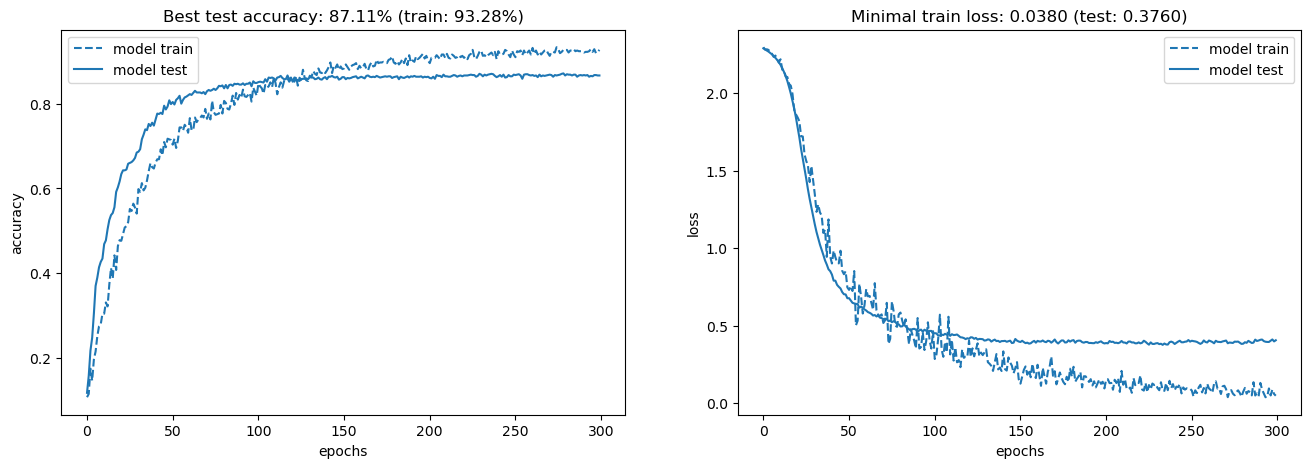

In [8]:
model = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    Dropout(0.5),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    Dropout(0.5),
    torch.nn.Linear(256, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
dropout_history = trainer.train(model, optimizer, n_epochs=n_epochs)
show_results(model=dropout_history)

### Zadanie 2. Batch Normalization (4 pkt.)

Batch Normalization jest techniką redukującą **internal covariate shift (przesunięcie rozkładu danych)** (ale czy na pewno? [[3]](https://arxiv.org/pdf/1805.11604.pdf)) poprzez normalizację wyjścia poszczególnych warstw. Wraz ze zmianą parametrów warstwy poprzedniej zmienia się domena zadania dla warstwy kolejnej. Dzięki normalizacji uczenie jest szybsze i bardziej stabilne - można użyć wyższych wartości współczynnika uczenia, normalizacja redukuje zanikanie i wybuchanie gradientów.

**Oznaczenia:**
* $ x_i $ - wektor z wejścia $x$ do warstwy BatchNorm
* $ y_i $ - wektor z wyjścia $y$ z warstwy BatchNorm
* $ \gamma $ - *scale*, uczony parametr, inicjalizowana na ???
* $ \beta $ - *shift*, uczony parametr, inicjalizowana na ???
* $ \overline{\mu} $ - średnia krocząca średniej batcha, inicjalizowana na ???
* $ \overline{\sigma} $ - średnia krocząca wariancji batcha, inicjalizowana na ???
* $\lambda$ - momentum do średnich kroczących



<font size=2> $$ \mu_B  = \frac{1}{m} \sum_{i=1}^m x_i $$ </font>
<font size=2>$$ \sigma^2_B  = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_b)^2 $$ </font>
<font size=2> $$ \hat{x_i} = \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}} $$ </font>
<font size=2> $$ y_i = \gamma \hat{x_i} + \beta $$ </font>

Dodatkowo potrzebujemy:

<font size=2> $$ \overline{\mu}_{t+1} =  (1 - \lambda) \overline{\mu}_{t} + \lambda \mu_B $$ </font>
<font size=2> $$ \overline{\sigma^2}_{t+1} =  (1 - \lambda) \overline{\sigma^2}_{t} + \lambda \sigma^2_B $$ </font>

**Pytania:**
1. Jak BN może zapobiegać zanikającym gradientom? Wytłumaczyć na przykładzie aktywacji sigmoidalnej $\sigma(x) = \frac{1}{1+e^{-x}}$.
2. Czy BN powinien być stosowany przed czy po aktywacji i dlaczego? (Wskazówka: nie ma złych odpowiedzi)
3. Czy można BN traktować jako regularyzację sieci neuronowej? Dlaczego?


**Odpowiedź na powyższe pytania jest częścią zadania. W poszukiwaniu odpowiedzi należy się posiłkować publikacjami dotyczącymi batch normalization [2, 3].**

1. Problem zanikającego gradientu polega na tym, że gradient spada do bardzo małej wartości, przez co aktualizacja gradientu praktycznie nie powoduje żadnych zmian w wagach danych warstw. Prościej mówiąc, szukając minimum, bardzo powoli poruszamy się, tracąc szansę kiedykolwiek do tego minimum dojść. W przypadku sigmoidalnej funkcji aktywacji, jej pochodna w punktach dalekich od 0 (w stronę +/- nieskończoności) jest bardzo bliska do 0. W momencie rozpoczęcia propagacji wstecznej wartość gradientu jest bardzo mała i staje się on jeszcze mniejszy w kolejnych krokach. BN normalizuje i wyśrodkowuje dane tuż przed funkcją aktywacji, pozwala modelowi określić optymalną skalę i średnią danych wejściowych dla każdej warstwy. Dzięki temu , że wartości są ustandaryzowane i przeskalowane, ogranicza się problem zanikania gradientu.

2. Według mnie, logiczniejszym jest wykorzystanie BN przed aktywacją, ponieważ chcemy, aby dla dowolnych wartości wejściowych parametrów wartości po aktywacji były z pożądanego rozkładu.

3. Batch Normalization nadaje się na regularyzację, ponieważ zasadniczo wprowadza ona szum. Wartości parametrów mnożone i odejmowane są przez losowe wartości (odchylenie standardowe i średnia losowo wybranego batcha) w każdym etapie uczenia. Oba te „szumy” sprawiają, że model będzie bardziej stabilny i zmniejszy się jego wariancja. Inaczej mówiąc wymusza to, żeby każda warstwa się uczyłą, aby być mniej wrażliwą na zmiany w wartościach wejsciowych.

Oba te „szumy” sprawią, że model będzie bardziej solidny i zmniejszy się jego wariancja.

In [6]:
class BatchNorm(torch.nn.Module):
    
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm, self).__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
            
        self.mu = torch.zeros(num_features)
        self.sigma = torch.ones(num_features)
        
        self.gamma = torch.nn.Parameter(torch.ones(num_features), requires_grad=True)
        self.beta = torch.nn.Parameter(torch.zeros(num_features), requires_grad=True)   

    def forward(self, x):
        if self.training:
            mean_batch = torch.mean(x)
            std_batch = torch.mean((x - mean_batch)**2)
            
            x_hat = (x - mean_batch) / torch.sqrt(std_batch + self.eps)
            y = self.gamma * x_hat + self.beta
            
            self.mu = (1 - self.momentum) * self.mu + self.momentum * mean_batch 
            self.sigma = (1 - self.momentum) * self.sigma + self.momentum * std_batch
            
            return y
        else:
            x_hat = (x - self.mu) / torch.sqrt(self.sigma + self.eps)
            return self.gamma * x_hat + self.beta
  

In [7]:
test_bn(BatchNorm)

Do modelu baseline'owego należy dodać Batch Normalization po każdej warstwie.

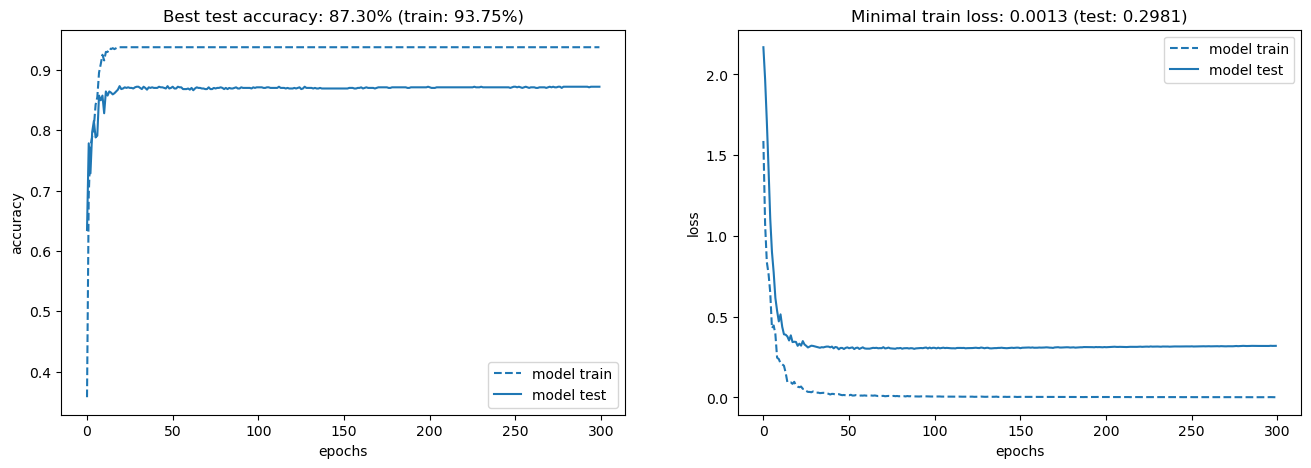

In [15]:
model = torch.nn.Sequential(torch.nn.Linear(784, 256), 
    BatchNorm(256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    BatchNorm(256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10))

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
bn_history = trainer.train(model, optimizer, n_epochs=n_epochs)
show_results(model=bn_history)

### Podsumowanie

Poniżej załączony oczekiwany rezultat eksperymentów dla zaproponowanych parametrów.

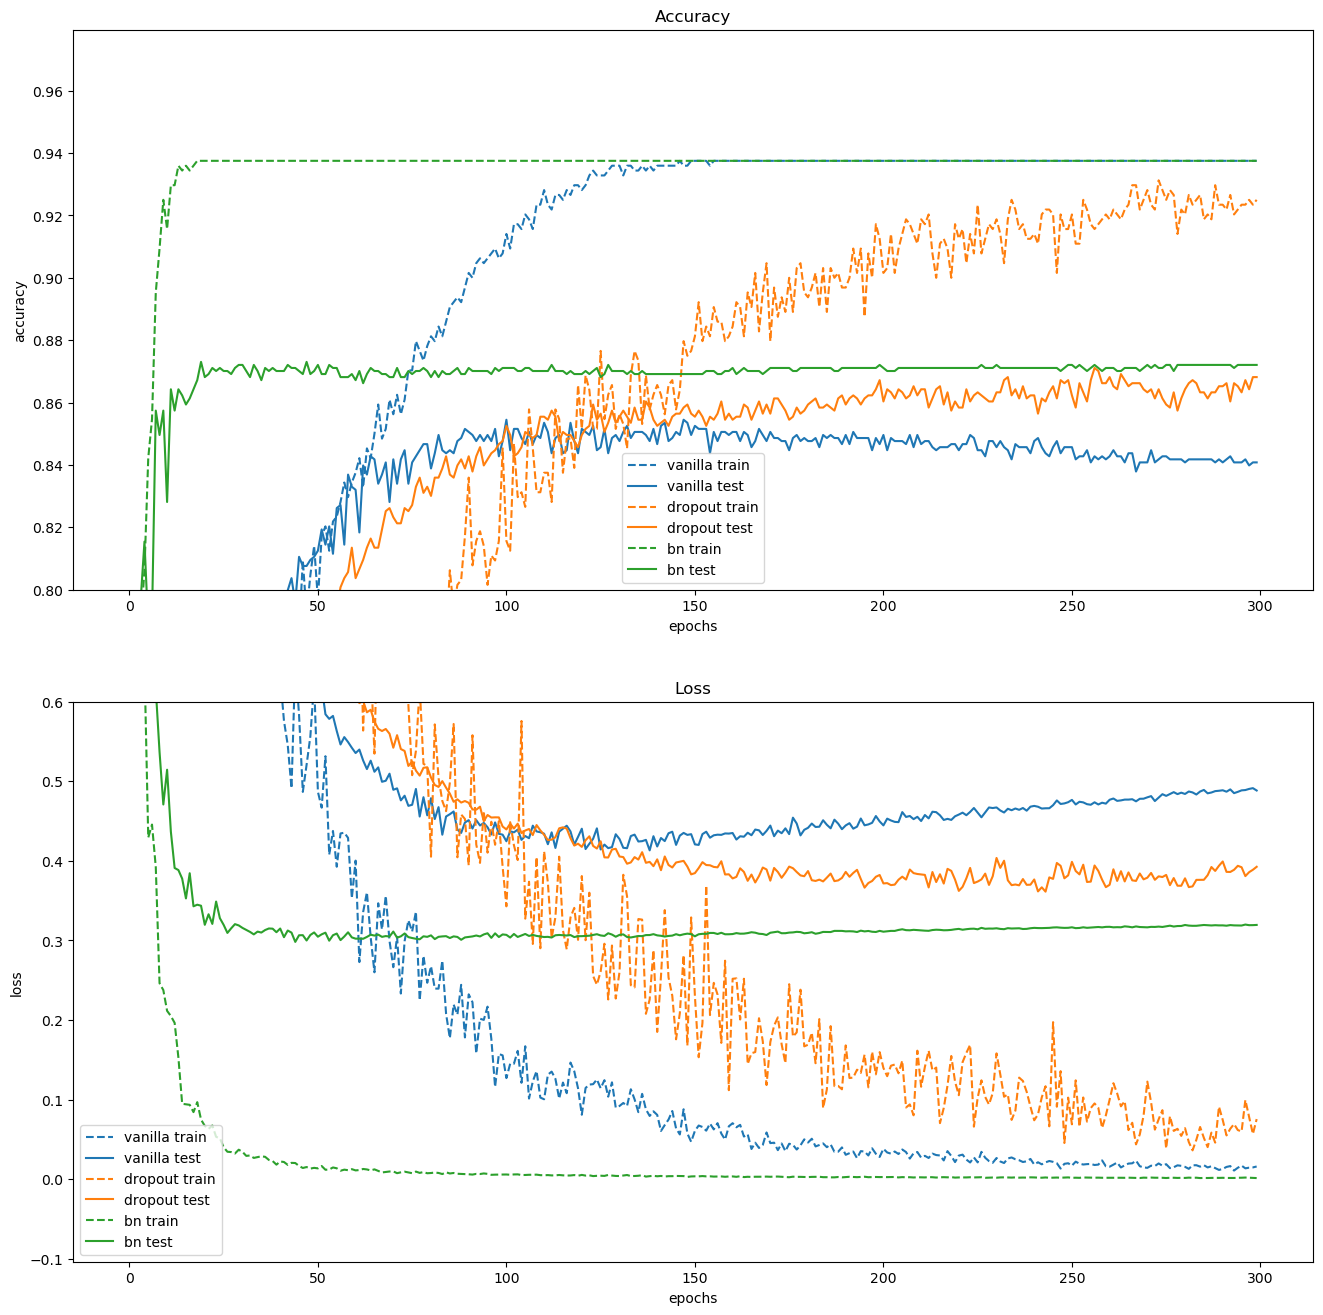

In [16]:
show_results(vanilla=history, dropout=dropout_history, bn=bn_history, 
             orientation='vertical', accuracy_bottom=0.8, loss_top=0.6)

### Literatura
 
1. [Srivastava, Nitish, et al. "Dropout: a simple way to prevent neural networks from overfitting."](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

2. [Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift."](https://arxiv.org/pdf/1502.03167.pdf)

3. [Santurkar, Shibani, et al. "How does batch normalization help optimization?(no, it is not about internal covariate shift)."](https://arxiv.org/pdf/1805.11604.pdf)